In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

from financepy.models.black import *
from financepy.models.bachelier import *
from financepy.models.black_shifted import *
from financepy.utils.global_types import *

import Fourier as fourier

%load_ext autoreload
%autoreload 2

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



### Setting up

In [2]:
def blackImpliedVol(forward,   # Forward rate F
                    K,         # Strike Rate K
                    T,         # Time to Expiry (years)
                    DF,        # df RFR to expiry date
                    callOrPut, # FinOptionTypes.EUROPEAN_CALL or FinOptionTypes.EUROPEAN_PUT
                    price
                    ):    
    min_ivol, max_ivol = 0.001, 1.0
    f = lambda ivol: Black(ivol).value(forward, K, T, DF, callOrPut) - price    
    return optimize.bisect(f, min_ivol, max_ivol)

def bachImpliedVol(forward,   # Forward rate F
                   K,         # Strike Rate K
                   T,         # Time to Expiry (years)
                   DF,        # df RFR to expiry date
                   callOrPut, # FinOptionTypes.EUROPEAN_CALL or FinOptionTypes.EUROPEAN_PUT
                   price
                   ):    
    min_bachvol, max_bachvol  = 0.001 * forward, 1.0 * forward    
    f = lambda bachvol: Bachelier(bachvol).value(forward, K, T, DF, callOrPut) - price    
    return optimize.bisect(f, min_bachvol, max_bachvol)

def SLNImpliedVol(forward,   # Forward rate F
                  K,         # Strike Rate K
                  T,         # Time to Expiry (years)
                  DF,        # df RFR to expiry date
                  callOrPut, # FinOptionTypes.EUROPEAN_CALL or FinOptionTypes.EUROPEAN_PUT
                  shift,
                  price
                  ):    
    factor = forward / (forward + shift)
    min_SLNvol, max_SLNvol  = 0.001 * factor, 1.0 * factor
    f = lambda SLNvol: BlackShifted(SLNvol, shift).value(forward, K, T, DF, callOrPut) - price    
    return optimize.bisect(f, min_SLNvol, max_SLNvol)

In [3]:
S0 = 0.02
r = 0.00
T = 1/12
DF = np.exp(-r*T)
forward = S0 / DF

#market quoted the option using 20% black vol
market_ATM_blackVol = 0.20
K = S0

# given a black implied vol at 20%, compute the call option price
blackmodel = Black(market_ATM_blackVol)
market_price = blackmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL)

print('market call option price = ' + str(market_price))

Bachelier(0.2 * forward).value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) - market_price

#---------------------------------------------------------
# calibrate the bachelier model to find out the bachelier implied vol
ATM_bachVol = bachImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, market_price)

print('calibrated Bachelier implied vol = ' + str(ATM_bachVol))

# compute the call option using the calibrated bachelier model
bachmodel = Bachelier(ATM_bachVol)
bach_call_value = bachmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL)

print('call option price under the calibrated Bachelier model  = ' + str(bach_call_value))

#---------------------------------------------------------
# calibrate the SLN model to find out the SLN implied vols
shifts = [0.0001, 0.005, 0.01, 0.1, 1]

ATM_SLN_vols = [SLNImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, shift, market_price) for shift in shifts]

SLNmodels = [BlackShifted(SLNvol, shift) for SLNvol, shift in zip(ATM_SLN_vols, shifts)]

market call option price = 0.00046059699591800146
calibrated Bachelier implied vol = 0.003999462770227111
call option price under the calibrated Bachelier model  = 0.0004605969960472956


### Figure 1 - Bachelier vs Black in lognormal implied vol

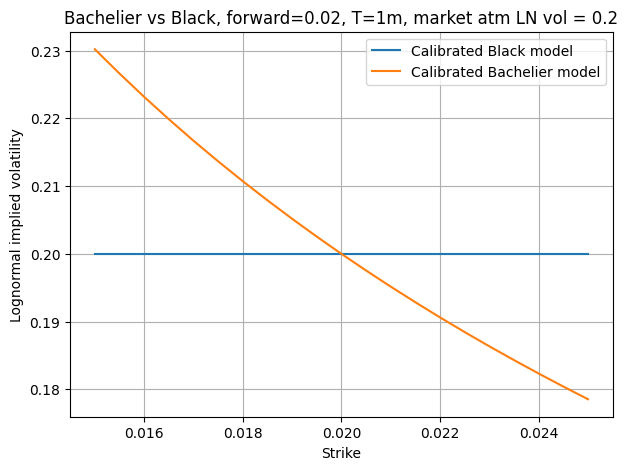

In [4]:
Ks = np.linspace(0.015, 0.025, 21)

black_call_vs = [blackmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) for K in Ks]
ivol_from_black_model = [blackImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, v) for v, K in zip(black_call_vs, Ks)]

bach_call_vs = [bachmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) for K in Ks]
ivol_from_bach_model = [blackImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, v) for v, K in zip(bach_call_vs, Ks)]

output = np.array([Ks, ivol_from_black_model, ivol_from_bach_model])
output = np.transpose(output)

df = pd.DataFrame(output, columns =['Strike', 'Calibrated Black model', 'Calibrated Bachelier model']) 
df = df.set_index('Strike')

df.plot(grid=True, figsize=(7, 5))
plt.title("Bachelier vs Black, forward=0.02, T=1m, market atm LN vol = 0.2")

plt.xlabel("Strike")
plt.ylabel("Lognormal implied volatility")

#plt.savefig("L4_Fig1.png")

plt.show()


### Figure 2 - Bachelier vs Black in normal implied vol

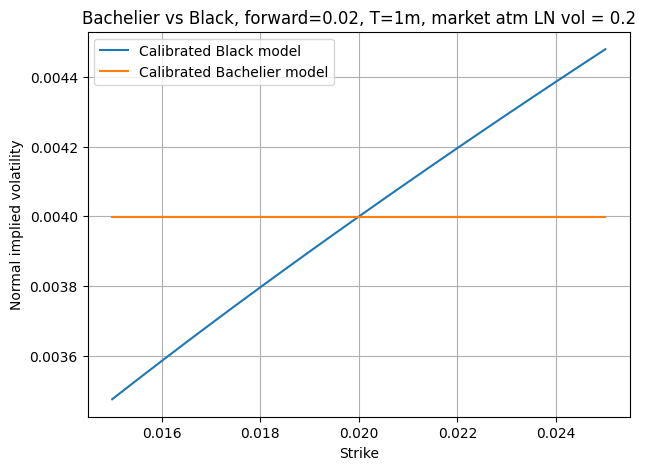

In [5]:
Ks = np.linspace(0.015, 0.025, 21)

black_call_vs = [blackmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) for K in Ks]
ivol_from_black_model = [bachImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, v) for v, K in zip(black_call_vs, Ks)]

bach_call_vs = [bachmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) for K in Ks]
ivol_from_bach_model = [bachImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, v) for v, K in zip(bach_call_vs, Ks)]

output = np.array([Ks, ivol_from_black_model, ivol_from_bach_model])
output = np.transpose(output)

df = pd.DataFrame(output, columns =['Strike', 'Calibrated Black model', 'Calibrated Bachelier model']) 
df = df.set_index('Strike')

df.plot(grid=True, figsize=(7, 5))
plt.title("Bachelier vs Black, forward=0.02, T=1m, market atm LN vol = 0.2")

plt.xlabel("Strike")
plt.ylabel("Normal implied volatility")

#plt.savefig("L4_Fig2.png")

plt.show()


### Figure 3 - SLN in lognormal implied vol

Text(0, 0.5, 'Lognormal implied volatility')

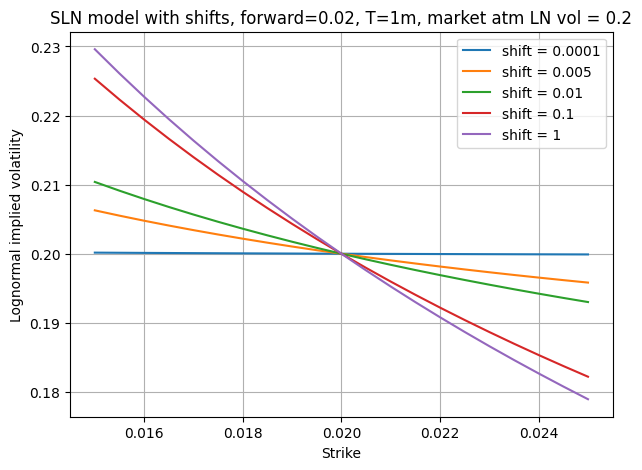

In [6]:
Ks = np.linspace(0.015, 0.025, 21)

df = pd.DataFrame()
df['Strike'] = Ks

for i, SLNmodel in enumerate(SLNmodels):

    sln_call_vs = [SLNmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) for K in Ks]
    ivol_from_sln_model = [blackImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, v) for v, K in zip(sln_call_vs, Ks)]
    
    df['shift = ' + str(shifts[i])] = np.array(ivol_from_sln_model)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("SLN model with shifts, forward=0.02, T=1m, market atm LN vol = 0.2")
plt.xlabel("Strike")
plt.ylabel("Lognormal implied volatility")    

#plt.savefig("L4_Fig3.png")

### Figure 4 - SLN in normal implied vol

Text(0, 0.5, 'Normal implied volatility')

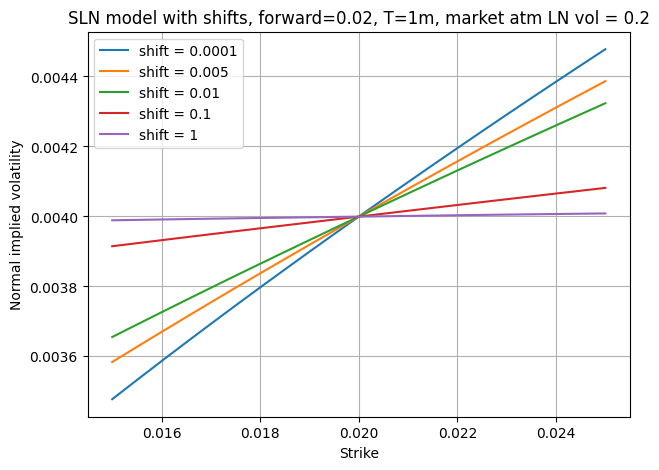

In [7]:
Ks = np.linspace(0.015, 0.025, 21)

df = pd.DataFrame()
df['Strike'] = Ks

for i, SLNmodel in enumerate(SLNmodels):

    sln_call_vs = [SLNmodel.value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) for K in Ks]
    ivol_from_sln_model = [bachImpliedVol(forward, K, T, DF, OptionTypes.EUROPEAN_CALL, v) for v, K in zip(sln_call_vs, Ks)]
    
    df['shift = ' + str(shifts[i])] = np.array(ivol_from_sln_model)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("SLN model with shifts, forward=0.02, T=1m, market atm LN vol = 0.2")
plt.xlabel("Strike")
plt.ylabel("Normal implied volatility")   

#plt.savefig("L4_Fig4.png")

### Figure 5 - Fourier Black vs Closed Form Black

Text(0, 0.5, 'Abs Difference in ivol')

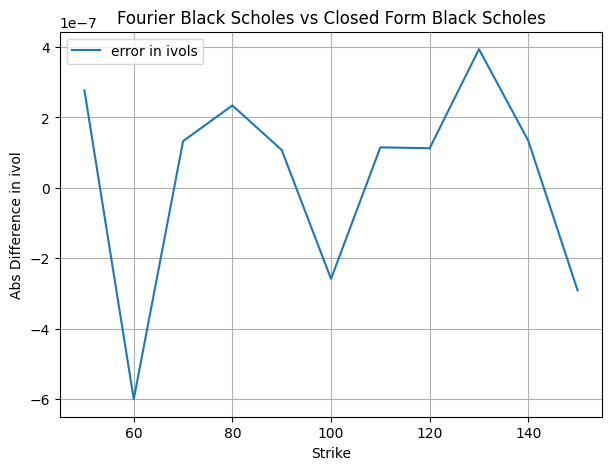

In [8]:
S0 = 100
Ts = [1]
r = 0.02
d = 0.03
vol = 0.5   
Ks = np.linspace(50, 150, 11)

callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks
for T in Ts:   
    DF = np.exp(-r*T)
    forward = S0 * np.exp((r-d)*T)    
    
    black_call_values = [Black(vol).value(forward, K, T, DF, callOrPut) for K in Ks]
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(black_call_values, Ks)]   
    
    ft_call_values = [DF * fourier.carr_madan_black_call_option(forward, vol, T, K) for K in Ks]   
    ft_ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(ft_call_values, Ks)]
   
    df['error in ivols'] = np.array(ivols) - np.array(ft_ivols)
    

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
#plt.ylim(-1E-4, 1E-4)
plt.title("Fourier Black Scholes vs Closed Form Black Scholes")
plt.xlabel("Strike")
plt.ylabel("Abs Difference in ivol")

#plt.savefig("L4_Fig5.png")